# Enhancing Art Classification: A Comparative Study of CNN, Transfer Learning, and SVM Models

### Part A: Basic Explorations & Data Loading

The dataset used is painter-by-numbers, obtained [here](https://www.kaggle.com/c/painter-by-numbers/data). The competition was designed for a pairwise comparison scheme in order to be applied in forgery recognition, however, we are leveraging the data to design a classifier that performs painter recognition, for 12 different artists.

The data is available in the `train.zip` and `test.zip` folders and all the relevant information is located in all_data_info.csv. In our approach, we retrieve all of the data (both train and test), filter out the artists that have less than 500 paintings, and then proceed with data analysis and modeling.

Our first step is to load the `all_data_info.csv` file to investigate it further. This file contains information about each painting in the dataset, such as the artist name, title of the painting, genre, style, and more. We use this information to perform initial data exploration and prepare the data for modeling.

In [1]:
# All the relevant modules and libraries
import itertools
import zipfile
import re
import logging

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import cv2
from PIL import Image
from skimage.feature import hog

from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from skimage.feature import hog, ORB
from skimage.filters import gabor
from sklearn.cluster import KMeans
from collections import Counter

from concurrent.futures import ThreadPoolExecutor

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision import transforms, models
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR

path = '/Users/adityaprakash/Downloads/PaintersDataset/'

df_info = pd.read_csv(path+'all_data_info.csv')
df_info.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [2]:
print(f"The full dataset contains a total of {len(df_info['artist'].unique())} different artists and {len(df_info['genre'].unique())} unique painting genres.\n")

The full dataset contains a total of 2319 different artists and 43 unique painting genres.



At this point, we must determine the most effective approach to filter the artists we will include in our dataset for classification. Although our dataset initially contains works from 2,319 artists, aiming to classify all these artists isn't practical. Moreover, for a robust and reliable classification model, we require a more balanced dataset.

One viable strategy involves setting a minimum threshold for the number of paintings an artist must have to be included in our dataset. This approach effectively filters out artists with very few paintings, thereby eliminating cases that might be more challenging to classify due to a lack of sufficient samples. At the same time, we retain a substantial number of samples for artists with many paintings, which facilitates a more accurate and nuanced classification.

To decide on an optimal threshold, we'll analyze the distribution of the number of paintings per artist. This will provide us with a clearer picture of the existing dataset's structure and help us choose a threshold that ensures a balanced and useful dataset for our purposes.

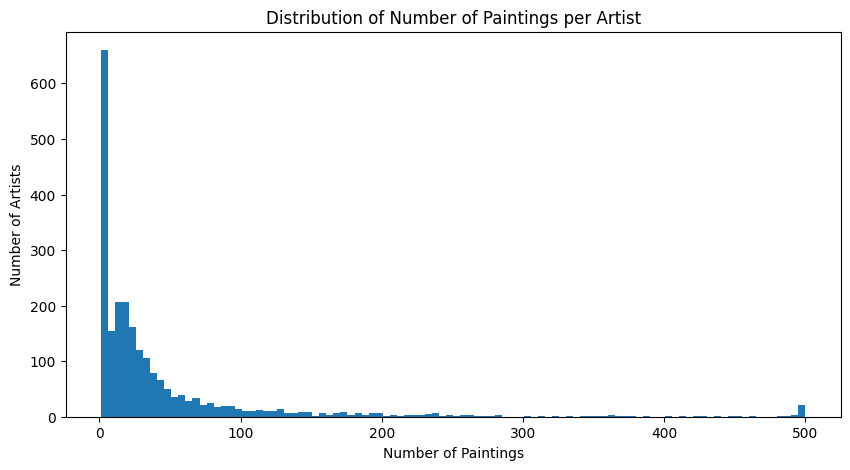

count    2319.000000
mean       44.523502
std        79.492145
min         1.000000
25%         1.000000
50%        19.000000
75%        44.000000
max       500.000000
Name: count, dtype: float64

In [3]:
import matplotlib.pyplot as plt

# Get the number of paintings per artist
artist_counts = df_info['artist'].value_counts()

# Plot the distribution of the number of paintings per artist
plt.figure(figsize=(10, 5))
plt.hist(artist_counts, bins=100)
plt.xlabel('Number of Paintings')
plt.ylabel('Number of Artists')
plt.title('Distribution of Number of Paintings per Artist')
plt.show()

# Display some statistics
artist_counts.describe()

The histogram above illustrates the distribution of the number of paintings per artist. As we can observe, there is a significant number of artists with a very small number of paintings. This is reflected in the fact that the 25th percentile is 1, indicating that at least 25% of artists have only one painting in the dataset. Conversely, the maximum number of paintings per artist is 500.

When setting a minimum threshold to include an artist in our dataset, we must weigh the trade-off between ensuring a more balanced dataset (which would require a higher threshold) and including a larger diversity of artists and paintings in our dataset (which would suggest a lower threshold).

We've decided to set a threshold of 500 paintings. This means we will only include artists in our dataset who have at least 500 paintings. There are several reasons why this could be a sensible decision:

1. **Balanced Classes**: By only including artists with at least 500 paintings, we're ensuring that our classes are balanced, which is crucial for many machine learning models. If one class (artist) has significantly more examples than others, the model might become biased towards predicting that class. By setting a high threshold, we ensure that each artist is well-represented in the dataset.

2. **Model Complexity**: With fewer artists, the model has a simpler task in distinguishing between them. This could lead to better performance, especially if the number of available paintings is limited. 

3. **Quality of Representation**: Artists with more paintings in the dataset are likely to have a broader range of their work represented. This could make it easier for the model to learn the defining characteristics of their style.

However, this threshold does come with a trade-off - we're excluding many artists from our dataset, which reduces the diversity of styles that our model will be exposed to. Therefore, this threshold should be adjusted based on further analysis and the performance of initial models. It's also possible that a model trained on this dataset might not perform as well when introduced to artists with fewer examples in the dataset.


In [4]:
# Set the threshold for the minimum number of paintings an artist needs to be included in the dataset
threshold = 500

# Filter the artists that have a number of paintings above the threshold
artists = df_info['artist'].value_counts()
artists_above_threshold = artists[artists >= threshold].index

# Filter the dataframe to include only the paintings from the selected artists
df_filtered = df_info[df_info['artist'].isin(artists_above_threshold)]

# Display the new dataframe
df_filtered.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
14,Ivan Aivazovsky,1873,marina,7444.0,5811.0,3189597.0,wikiart,Romanticism,Storm at sea,train_and_test,True,99442.jpg
28,Gustave Dore,1866,religious painting,4915.0,6068.0,29811319.0,wikiart,Romanticism,Death of Eleazer,train_and_test,True,7486.jpg
29,Gustave Dore,NaN,religious painting,4770.0,6219.0,32443139.0,wikiart,Romanticism,The-Deluge,train_and_test,True,35766.jpg
34,Gustave Dore,NaN,illustration,5878.0,4678.0,24158097.0,wikiart,Romanticism,The hoarders and wasters,train_and_test,False,31977.jpg
82,Ivan Aivazovsky,1850,marina,5815.0,3840.0,16019462.0,wikiart,Romanticism,The Ninth Wave,train_and_test,True,81750.jpg


In [5]:
print(f"The filtered dataset contains a total of {len(df_filtered['artist'].unique())} different artists and {len(df_filtered['genre'].unique())} unique painting genres.\n")

print("The artists are:")
for artist in df_filtered['artist'].unique():
    print(f"- {artist}")

The filtered dataset contains a total of 12 different artists and 30 unique painting genres.

The artists are:
- Ivan Aivazovsky
- Gustave Dore
- Rembrandt
- Pierre-Auguste Renoir
- Albrecht Durer
- Ivan Shishkin
- Giovanni Battista Piranesi
- John Singer Sargent
- Zdislav Beksinski
- Ilya Repin
- Pablo Picasso
- Marc Chagall


## Encoding Artist Names

Machine learning models typically work with numerical data, and our artist names are categorical (textual) data. To convert these textual artist names into a format that our model can work with, we employ a process called "encoding".

For this, we use the LabelEncoder from sklearn.preprocessing. The LabelEncoder transforms each unique artist name into a unique integer.

The code is as follows:

In [6]:
# Get the list of unique artist names
artist_names = df_filtered['artist'].unique().tolist()

# Create a LabelEncoder to transform artist names into integers
artist_encoder = preprocessing.LabelEncoder()
artist_encoder.fit(artist_names)

LabelEncoder()

## Data Augmentation

Data augmentation is an effective way to artificially increase the size of your training dataset. By applying slight modifications to the original images, we can generate new training samples that help in making our models more robust and reduce the chances of overfitting. Common augmentations include rotations, translations, scalings, and flips.

In the context of deep learning and computer vision, data augmentation can be especially useful. Many deep learning models require a large amount of data to perform well, and data augmentation can help in situations where the dataset is limited in size.

Below is a Python class `ImageTransformer` which helps in transforming images based on the provided configurations. This class provides options for normalizing the image, cropping it, and resizing it. The transformed image can be visualized directly using the `visualize` method of the class.

Original Image:


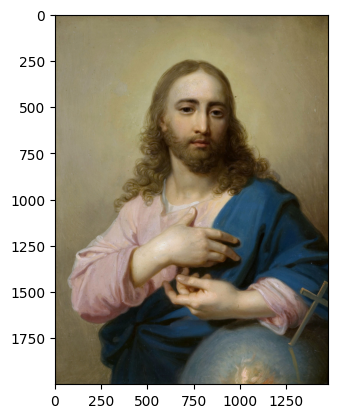

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Transformed Image:


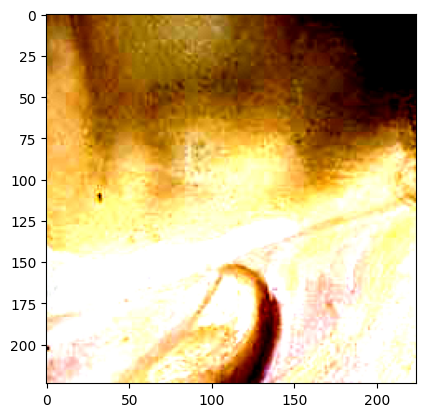

In [7]:
# Import necessary libraries
from torchvision import transforms
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

# Define the ImageTransformer class for various image transformations
class ImageTransformer:
    def __init__(self, new_dim=224, apply_norm=True, crop_img=True, training=False):
        self.new_dim = new_dim
        self.apply_norm = apply_norm
        self.crop_img = crop_img
        self.training = training
        self.normalizer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        if training:
            self.transform = transforms.Compose([
                transforms.RandomRotation(15),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                self.ensure_rgb,
                self.normalizer if apply_norm else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(self.new_dim) if crop_img else self.resize_and_pad
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                self.ensure_rgb,
                self.normalizer if apply_norm else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(self.new_dim) if crop_img else self.resize_and_pad
            ])

    def resize_and_pad(self, image):
        # Resize while maintaining aspect ratio
        width, height = image.shape[2], image.shape[1]
        if width < height:
            image = image.transpose(1, 2)
        
        res_percent = self.new_dim / max(width, height)
        new_width, new_height = round(width * res_percent), round(height * res_percent)
        image = transforms.Resize((new_height, new_width), antialias=True)(image)
        
        # Apply padding to make it square (new_dim x new_dim)
        padding = (0, 0, self.new_dim - new_width, self.new_dim - new_height)
        image = transforms.Pad(padding)(image)
        
        return image
        
    # Ensure the image is in RGB format
    def ensure_rgb(self, image):
        channels = image.shape[0]
        # If grayscale, repeat channel to make it RGB
        if channels == 1:
            return image.repeat(3, 1, 1)
        # If there are more than 3 channels, keep only the first three
        elif channels > 3:
            return image[:3]
        return image

    # Apply the desired transformations to the image
    def transform(self, image):
        # Convert to tensor
        image = self.tensoring(image)
        # Ensure RGB format
        image = self.ensure_rgb(image)

        # Normalize if flag is set
        if self.apply_norm:
            image = self.normalizer(image)
        
        # Apply center crop if flag is set
        if self.crop_img:
            image = transforms.CenterCrop(self.new_dim)(image)
        else:
            # Resize while maintaining aspect ratio
            width, height = image.shape[2], image.shape[1]
            if width < height:
                image = image.transpose(1, 2)
            
            res_percent = self.new_dim / max(width, height)
            new_width, new_height = round(width * res_percent), round(height * res_percent)
            image = transforms.Resize((new_height, new_width), antialias=True)(image)
            
            # Apply padding to make it square (new_dim x new_dim)
            padding = (0, 0, self.new_dim - new_width, self.new_dim - new_height)
            image = transforms.Pad(padding)(image)

        return image

    # Visualize the transformed image
    def visualize(self, image):
        image = self.transform(image)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.show()

# Load an example image from a ZIP archive for demonstration
archive = zipfile.ZipFile(path + 'train.zip', 'r')
imgdata = archive.open('train/212.jpg')
image = Image.open(imgdata)

# Instantiate the transformer
transformer = ImageTransformer()

# Display original image
print("Original Image:")
plt.imshow(image)
plt.show()

# Display transformed image using the transformer
print("Transformed Image:")
transformer.visualize(image)


### Custom Image Dataset Class

In order to efficiently load and process the painting images for training a deep learning model, we define a custom dataset class, `CustomImageDataset`, that inherits from PyTorch's `Dataset` class. This class is responsible for handling the following operations:

1. **Initialization (`__init__`):** Accepts the path to the ZIP archives, a DataFrame containing image information, a label encoder for transforming artist names into integers, and optional image transformations. It then loads all the images and their corresponding labels.

2. **Loading Individual Image (`load_image`):** Loads a single image from the ZIP archive, applies any specified transformations, and returns the image tensor and the corresponding artist label.

3. **Loading Images from Archive (`load_images_from_archive`):** Loads all images from a specific ZIP archive (either training or testing) by iterating through the DataFrame and calling the `load_image` method.

4. **Loading All Images (`load_all_images`):** Combines the loading of training and testing images and returns tensors of images and corresponding labels.

5. **Length Method (`__len__`):** Returns the total number of samples in the dataset.

6. **Get Item Method (`__getitem__`):** Retrieves the image and label at a specific index, allowing the dataset to be indexed like a list.

This custom dataset class provides a convenient and efficient way to manage the image data and integrates seamlessly with PyTorch's DataLoader for batching and shuffling during model training.


In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, path, dataframe, lab_encoder, transformations=None):
        """
        Initialize the custom dataset.
        
        Args:
            path (string): Directory with the image files (ZIP archives).
            dataframe (pd.DataFrame): DataFrame containing the image information.
            lab_encoder: Label encoder to transform the artist's names into integers.
            transformations (callable, optional): Optional transformations to apply to images.
        """
        self.path = path
        self.dataframe = dataframe
        self.encoder = lab_encoder
        self.transformations = transformations
        self.images, self.labels = self.load_all_images()  # Load all images

    def load_image(self, archive, img_path, file_name, artist):
        """
        Load a single image from the ZIP archive.

        Args:
            archive (ZipFile): The ZIP archive containing the image.
            img_path (str): Path within the ZIP archive to the image.
            file_name (str): Name of the image file.
            artist (str): Artist label for the image.

        Returns:
            (torch.Tensor, int): Image tensor and corresponding label, or (None, None) if an error occurred.
        """
        try:
            imgdata = archive.open(img_path + file_name)
            image = Image.open(imgdata)
            if self.transformations:
                image = self.transformations(image)  # Apply transformations if any
            return image, self.encoder.transform([artist])[0]
        except Exception as e:
            logging.warning(f"Skipped loading image {file_name} due to an error: {e}")
            return None, None

    def load_images_from_archive(self, archive_path, img_path, dataframe):
        """
        Load all images from a given ZIP archive.
`
        Args:
            archive_path (str): Path to the ZIP archive.
            img_path (str): Path within the ZIP archive to the images.
            dataframe (pd.DataFrame): DataFrame containing information about the images.

        Returns:
            (list, list): Lists of image tensors and corresponding labels.
        """
        feats, labels = [], []
        with zipfile.ZipFile(archive_path, 'r') as archive:
            for index, row in dataframe.iterrows():
                image, label = self.load_image(archive, img_path, row['new_filename'], row['artist'])
                if image is not None:
                    feats.append(image)
                    labels.append(label)
        return feats, labels

    def load_all_images(self):
        """
        Load all images from both training and testing ZIP archives.

        Returns:
            (torch.Tensor, torch.Tensor): Tensors of images and corresponding labels.
        """
        # Load training images
        train_df = self.dataframe[self.dataframe['in_train'] == True]
        train_feats, train_labels = self.load_images_from_archive(self.path + 'train.zip', 'train/', train_df)

        # Load testing images
        test_df = self.dataframe[self.dataframe['in_train'] == False]
        test_feats, test_labels = self.load_images_from_archive(self.path + 'test.zip', 'test/', test_df)

        # Combine and convert to tensors
        feats = torch.stack(train_feats + test_feats)
        labels = torch.LongTensor(train_labels + test_labels)
        return feats, labels

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve the image and label at a specific index.

        Args:
            idx (int): Index of the sample.

        Returns:
            (torch.Tensor, int): Image tensor and corresponding label.
        """
        return self.images[idx], self.labels[idx]


### Preparing the Training, Validation, and Test Datasets

After defining the custom dataset class, the next step is to prepare the datasets for training, validation, and testing. Here's an overview of the process carried out in this code cell:

1. **Splitting the Data:** The original DataFrame containing the filtered data is split into three parts: training (60%), validation (25%), and testing (15%). This ensures that the model can be trained, validated, and tested on different subsets of the data.

2. **Defining Image Transformations:** Two types of image transformers are defined – one for training data (`train_transformer`) and another for validation and testing data (`val_test_transformer`). These transformers include resizing the images to 224x224 and applying normalization. The training transformer also includes data augmentation techniques.

3. **Creating Custom Datasets:** Instances of the `CustomImageDataset` class are created for the training, validation, and testing data. These instances include the specific transformations defined earlier.

4. **Creating DataLoaders:** PyTorch's `DataLoader` class is used to create data loaders for each dataset. These data loaders handle the batching and shuffling of the data and will be used to iterate over the datasets during the training, validation, and testing phases.

5. **Setting the Batch Size:** The batch size, set to 32, determines the number of samples that will be processed simultaneously during model training.

By organizing the data into training, validation, and test datasets and defining the appropriate transformations and data loaders, the data is now ready to be used in training a deep learning model. The use of a custom dataset class and PyTorch's DataLoader ensures flexibility and efficiency in handling the data.


In [9]:
from sklearn.model_selection import train_test_split

# File path and other parameters
file_path = '/Users/adityaprakash/Downloads/PaintersDataset/'
active_df = df_filtered # DataFrame containing your data
LabEnc = artist_encoder # Label encoder object

# Split active_df into training, validation, and test sets
train_df, test_df = train_test_split(active_df, test_size=0.4, random_state=420)
val_df, test_df = train_test_split(test_df, test_size=0.375, random_state=420)

# Define the transformers
train_transformer = ImageTransformer(new_dim=224, apply_norm=True, crop_img=False, training=True)
val_test_transformer = ImageTransformer(new_dim=224, apply_norm=True, crop_img=False, training=False)

# Create custom image datasets with transformations
train_data = CustomImageDataset(path=file_path, dataframe=train_df, lab_encoder=LabEnc, transformations=train_transformer.transform)
val_data = CustomImageDataset(path=file_path, dataframe=val_df, lab_encoder=LabEnc, transformations=val_test_transformer.transform)
test_data = CustomImageDataset(path=file_path, dataframe=test_df, lab_encoder=LabEnc, transformations=val_test_transformer.transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Building and Training the Custom Convolutional Neural Network (CNN)

This section of the code focuses on building, training, evaluating, and visualizing a custom CNN for image classification. The main components are:

1. **Define the Device:** The code first checks whether a GPU (with CUDA) is available and sets the computation device accordingly.

2. **Custom CNN Definition:** The `CustomCNN` class is defined to create a CNN model with customizable convolutional and fully connected layers. The model also supports batch normalization and dropout.

3. **Training Function (`train_cnn`):** A function to handle the training process, including loss computation, backpropagation, and optimization. It also includes early stopping based on validation loss.

4. **Evaluation Function (`evaluate_cnn`):** A function to evaluate the model on a given dataset (e.g., validation or test set). It returns the average loss and accuracy.

5. **Plotting Functions:** Functions to plot the training and validation losses and accuracies (`plot_training_curves`) and the confusion matrix (`plot_confusion_matrix`) for visual analysis of the model's performance.

6. **Model Parameters:** Convolutional and fully connected layer parameters are defined, along with the dropout rate and batch normalization setting.

7. **Model Initialization:** The custom CNN is initialized with the defined parameters and moved to the chosen computation device.

8. **Loss Function and Optimizer:** The Cross-Entropy Loss is chosen as the loss function, and the Adam optimizer is used for optimization. A learning rate scheduler is also defined.

9. **Model Training:** The training function is called with the appropriate parameters, including the model, data loaders, loss function, optimizer, and training settings such as the number of epochs, patience for early stopping, and verbosity frequency.

10. **Visualizing Training Curves:** The training and validation losses and accuracies are plotted to analyze how the model learned over the epochs.

11. **Visualizing Confusion Matrix:** The confusion matrix is plotted for the validation set to understand how the model performs on each class.

By defining a custom CNN architecture and accompanying training and evaluation functions, this code provides a flexible and robust framework for training deep learning models for image classification. The visualizations further aid in understanding the model's behavior and performance.


Epoch 0: Training Loss = 2.318280005876997, Validation Loss = 2.103616199594863, Training Accuracy = 19.71875, Validation Accuracy = 0.2540632486343384
Epoch 1: Training Loss = 1.9908254768996112, Validation Loss = 1.8502742939807, Training Accuracy = 32.53125, Validation Accuracy = 0.3650512397289276
Epoch 2: Training Loss = 1.8266305934011409, Validation Loss = 1.7398856066642923, Training Accuracy = 39.6875, Validation Accuracy = 0.3823384642601013
Epoch 3: Training Loss = 1.7191559645981915, Validation Loss = 1.6026996247311855, Training Accuracy = 45.21875, Validation Accuracy = 0.4392237961292267
Epoch 4: Training Loss = 1.650781528084679, Validation Loss = 1.5309341664009906, Training Accuracy = 48.25, Validation Accuracy = 0.4716804623603821
Epoch 5: Training Loss = 1.6021757674428214, Validation Loss = 1.4558456730335316, Training Accuracy = 50.5, Validation Accuracy = 0.514356791973114
Epoch 6: Training Loss = 1.5418179383320092, Validation Loss = 1.4719351149619895, Training

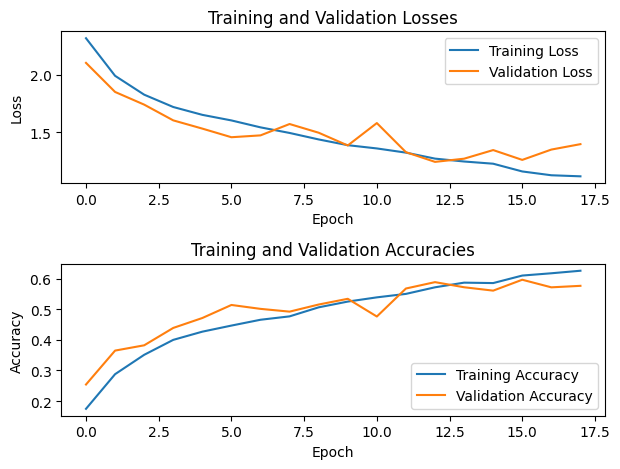

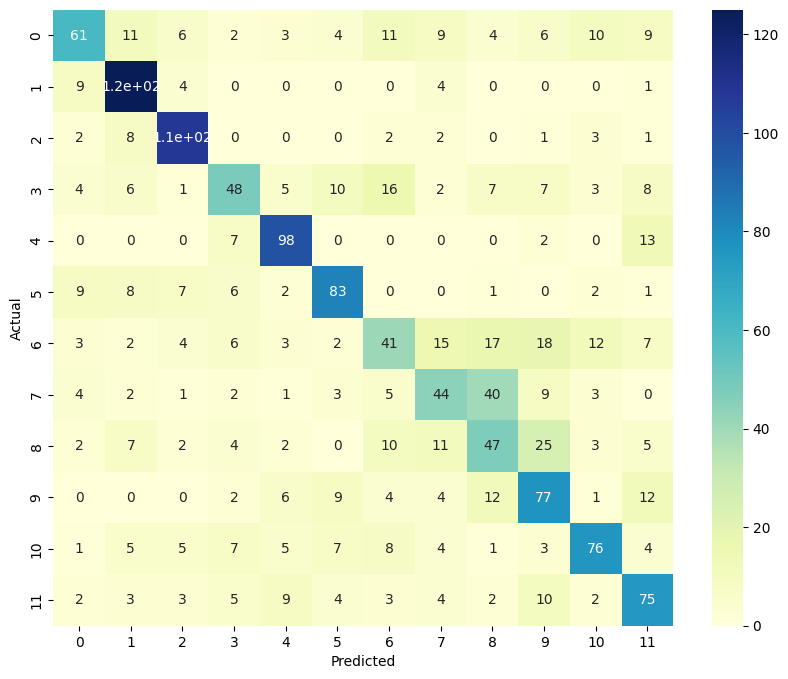

In [ ]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Custom CNN definition
class CustomCNN(nn.Module):
    # Initialization
    def __init__(self, conv_params, fc_params, dropout_rate, use_batch_norm):
        super(CustomCNN, self).__init__()
        self.conv_layers = self._build_conv_layers(conv_params, use_batch_norm)
        self.fc_layers = self._build_fc_layers(conv_params, fc_params, dropout_rate)

    # Build Convolutional Layers
    def _build_conv_layers(self, conv_params, use_batch_norm):
        layers = []
        for i in range(len(conv_params['kernels'])):
            layers += self._conv_block(conv_params['channels'][i], conv_params['channels'][i+1],
                                       conv_params['kernels'][i], conv_params['maxpools'][i],
                                       use_batch_norm)
        layers.append(nn.AdaptiveAvgPool2d(1)) # Adaptive Pooling Layer
        layers.append(nn.Flatten())
        return nn.Sequential(*layers)

    # Convolutional Block
    def _conv_block(self, in_channels, out_channels, kernel_size, pool_size, use_batch_norm):
        block = [
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1, stride=2),
        ]
        if use_batch_norm:
            block.append(nn.BatchNorm2d(num_features=out_channels))
        block.append(nn.ReLU())
        block.append(nn.MaxPool2d(kernel_size=pool_size))
        # He initialization
        nn.init.kaiming_normal_(block[0].weight, nonlinearity='relu')
        return block


    # Build Fully Connected Layers
    def _build_fc_layers(self, conv_params, fc_params, dropout_rate):
        dummy_input = torch.zeros(1, conv_params['channels'][0], 224, 224)
        first_fc_in_features = self.conv_layers(dummy_input).size(-1)
        layers = [nn.Linear(first_fc_in_features, fc_params[0])]
        for i in range(len(fc_params) - 1):
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(fc_params[i], fc_params[i+1]))
        return nn.Sequential(*layers)


    # Forward Pass
    def forward(self, x):
        x = self.conv_layers(x)
        return self.fc_layers(x)

# Training Function
def train_cnn(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs, device="cuda", patience=None, verbose_freq=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_loss = float('inf')
    patience_counter = 0
    model_path = 'model.pt'

    def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0, 0
        for batch in train_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(outputs, targets)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc / len(train_loader))

        val_loss, val_acc = evaluate_cnn(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        if val_loss < best_loss - 1e-4:
            best_loss = val_loss
            torch.save(model.state_dict(), model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience and patience_counter >= patience:
                print(f"Early stopping after {patience} epochs of no improvement.")
                break

        if epoch % verbose_freq == 0:
            print(f"Epoch {epoch}: Training Loss = {train_loss}, Validation Loss = {val_loss}, Training Accuracy = {train_acc}, Validation Accuracy = {val_acc}")

    model.load_state_dict(torch.load(model_path))
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_cnn(model, data_loader, loss_fn, device="cuda"):
    model.eval()
    total_loss, total_acc = 0, 0

    def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)

    return total_loss / len(data_loader), total_acc / len(data_loader)

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, filename='plot.png'):
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    
    plt.subplot(2, 1, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracies")
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def plot_confusion_matrix(model, data_loader, device="cuda"):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap="YlGnBu")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Model Parameters
conv_params = {'channels': [3, 16, 32, 64], 'kernels': [3, 3, 3], 'maxpools': [2, 2, 2]} # Added more layers
fc_params = [64, 128, 64, 12] # More complex fully connected layers
dropout_rate = 0.25
use_batch_norm = True

# Model, Loss Function, and Optimizer
model = CustomCNN(conv_params, fc_params, dropout_rate, use_batch_norm).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=15, gamma=0.8) 

# Training the Model
train_losses, val_losses, train_accuracies, val_accuracies = train_cnn(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs=50, device=device, patience=5, verbose_freq=1)

# Plotting the Training Curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

#Plotting the confusion matrix
plot_confusion_matrix(model, val_loader, device)

### Training Results Summary

The custom Convolutional Neural Network (CNN) was trained for 17 epochs, including an early stopping mechanism after 5 epochs of no improvement. Below is a summary of the training process:

- **Epoch 0:** Started with a training loss of 2.32 and validation loss of 2.10, achieving a training accuracy of 19.72% and validation accuracy of 25.41%.
- **Epoch 1-5:** Gradual improvement observed in both training and validation losses and accuracies, reaching a validation accuracy of 51.44% by Epoch 5.
- **Epoch 6-9:** Some fluctuations in validation loss were noted, with overall continued improvement in validation accuracy, reaching 53.45% by Epoch 9.
- **Epoch 10-11:** A temporary drop in validation accuracy to 47.66% in Epoch 10, followed by a significant jump to 56.82% in Epoch 11.
- **Epoch 12-14:** Continued improvement in training accuracy and validation accuracy, peaking at 58.91% in Epoch 12, but with some fluctuations in validation loss.
- **Epoch 15-16:** Final stages of training, reaching a training accuracy of 69.84% and validation accuracy of 59.69% in Epoch 16.
- **Early Stopping:** The training was terminated early after 5 epochs of no improvement in validation loss, as per the early stopping criterion.

Overall, the training process showed a clear trend of decreasing loss and increasing accuracy, reflecting the model's ability to learn from the training data. The early stopping mechanism helped prevent potential overfitting and ensured that the model was selected based on optimal validation performance.

The final validation accuracy of 59.69% indicates a reasonable ability of the model to generalize to unseen data, and the plot of training and validation losses and accuracies (if available) can provide further insights into the learning dynamics.

The results may be further improved by fine-tuning the model architecture, hyperparameters, or employing additional regularization techniques.


### Model Evaluation on Test Set

After training the custom Convolutional Neural Network (CNN) on the training data and validating its performance on the validation set, it is essential to evaluate the model's performance on an unseen test set. This step ensures that we assess the model's ability to generalize to new, unseen data, which is crucial for understanding how the model may perform in a real-world scenario.

In this section, the following steps will be performed:
1. **Evaluate the Model:** The trained model will be evaluated on the test set, and the loss and accuracy metrics will be computed. This will provide quantitative insights into how well the model performs on data it has not encountered during training.
2. **Confusion Matrix:** A confusion matrix will be plotted to visualize the model's predictions across different classes. This matrix will help in understanding where the model is making mistakes and which classes are being confused with each other.

By analyzing these results, we can make final conclusions about the model's performance and its suitability for the given task. The test set evaluation is a critical step in the machine learning pipeline, providing a final assessment of the model's quality and robustness.


Test Loss: 1.261461463467828
Test Accuracy: tensor(0.5970)


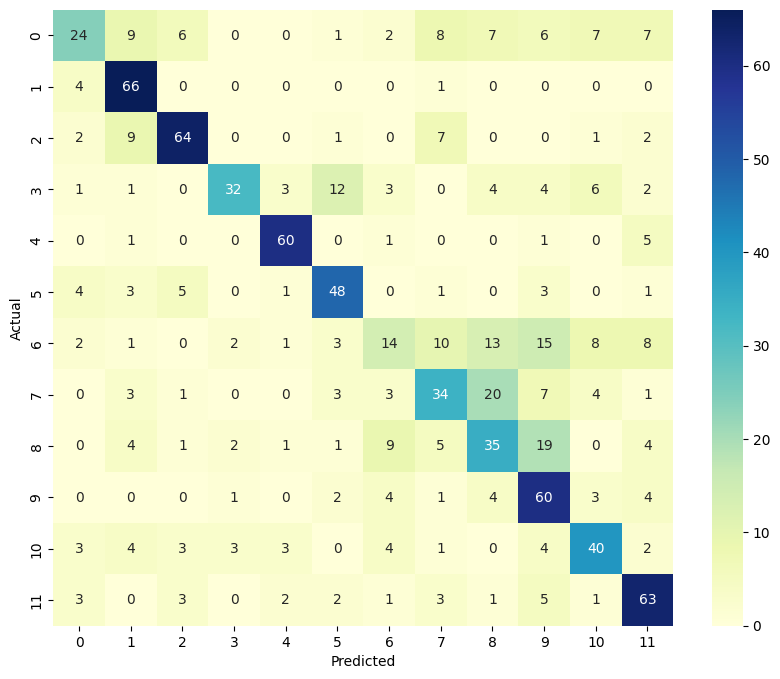

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_cnn(model, test_loader, loss_fn, device)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot the confusion matrix for the test set
plot_confusion_matrix(model, test_loader, device)


### Test Set Evaluation Results

The final evaluation of the model on the test set yielded the following results:

- **Test Loss:** 1.2615
- **Test Accuracy:** 59.70%

These results provide a quantitative measure of how well the trained model is performing on unseen data. The test accuracy of approximately 59.70% indicates that the model is correctly classifying around 59.70% of the test samples. While the model has learned some patterns from the training data, there may still be room for further optimization and improvement.

The test loss and accuracy are critical metrics in understanding the model's generalization ability. They provide insights into how well the model might perform in a real-world scenario, where it has to make predictions on data it has never encountered before.

It's worth considering further experiments with different architectures, hyperparameters, or preprocessing techniques to potentially improve these metrics. The analysis of the confusion matrix, if plotted, could also provide more detailed insights into the specific areas where the model might be struggling.

Overall, the test set evaluation confirms the model's ability to make predictions on new data, providing a baseline for its performance on the given task.


### Utilizing Pre-Trained ResNet-50 for Image Classification

In this section, we explore the use of a pre-trained ResNet-50 model to perform image classification. ResNet-50 is a deep residual network with 50 layers and has achieved impressive performance on various visual recognition tasks. Leveraging the pre-trained weights can be a powerful strategy, as the model has already learned essential features from a vast dataset (like ImageNet) and can be fine-tuned to suit our specific task.

#### Steps Involved:

1. **Data Preparation**: The dataset is split into training, validation, and test sets. Specific image transformations are applied to the training and validation/test sets, considering the input requirements of ResNet-50.

2. **Loading ResNet-50**: We utilize the pre-trained ResNet-50 model, assuming IMAGENET1K_V2 weights. The model has already learned valuable hierarchical features from the vast ImageNet dataset.

3. **Model Modification**: The last fully connected layer of ResNet-50 is modified to match the number of classes in our dataset. This ensures that the model's output corresponds to our classification problem.

4. **Training Configuration**: Loss function, optimizer, and learning rate scheduler are defined, with some adjustments to the learning rate and step size for our specific problem.

5. **Model Training**: The model is trained using the custom training function on the training set, validating it on the validation set. Training curves and confusion matrices are plotted to visualize the learning process.

6. **Test Evaluation**: Finally, the model is evaluated on the test set to understand its performance on unseen data. A confusion matrix for the test set can also be plotted for detailed insights.

By employing the pre-trained ResNet-50 model, we leverage the power of transfer learning. This often leads to faster convergence and potentially better performance, as the model has already been trained on a diverse set of images. It allows us to utilize the pre-existing knowledge of the model and adapt it to our specific classification task.

The following code cell carries out these steps, and we will analyze the results in the subsequent sections.


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0: Training Loss = 1.8158274385664197, Validation Loss = 1.4588546492951981, Training Accuracy = 91.625, Validation Accuracy = 0.5160783529281616
Epoch 1: Training Loss = 1.3790226896603903, Validation Loss = 1.5106567898963361, Training Accuracy = 124.25, Validation Accuracy = 0.5236943960189819
Epoch 2: Training Loss = 1.1788551545143127, Validation Loss = 1.0101230485325163, Training Accuracy = 138.875, Validation Accuracy = 0.6991658210754395
Epoch 3: Training Loss = 0.9839473504490323, Validation Loss = 1.1219014668084206, Training Accuracy = 151.9375, Validation Accuracy = 0.6503868699073792
Epoch 4: Training Loss = 0.9037241458892822, Validation Loss = 1.0922831553728023, Training Accuracy = 160.3125, Validation Accuracy = 0.6607229113578796
Epoch 5: Training Loss = 0.8149852404329512, Validation Loss = 0.9755052266285774, Training Accuracy = 163.875, Validation Accuracy = 0.7108317613601685
Epoch 6: Training Loss = 0.6951873874664307, Validation Loss = 0.930064837824791, 

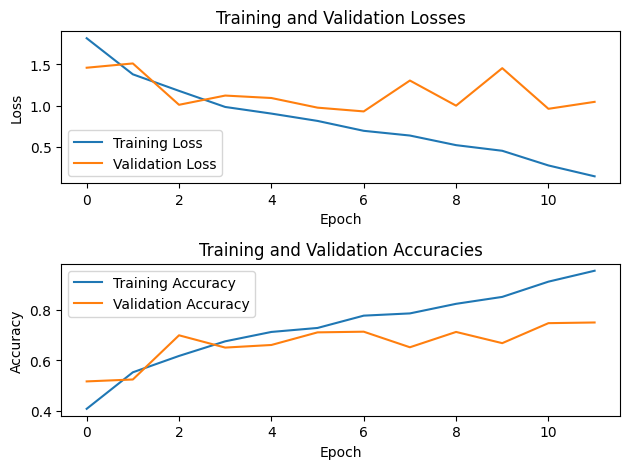

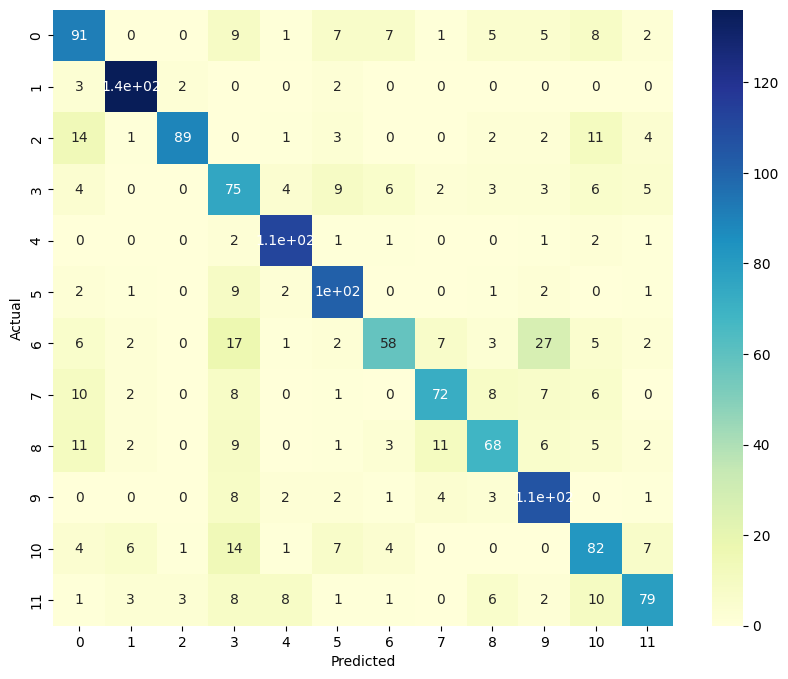

Test Loss: 0.9001387381239941
Test Accuracy: tensor(0.7237)


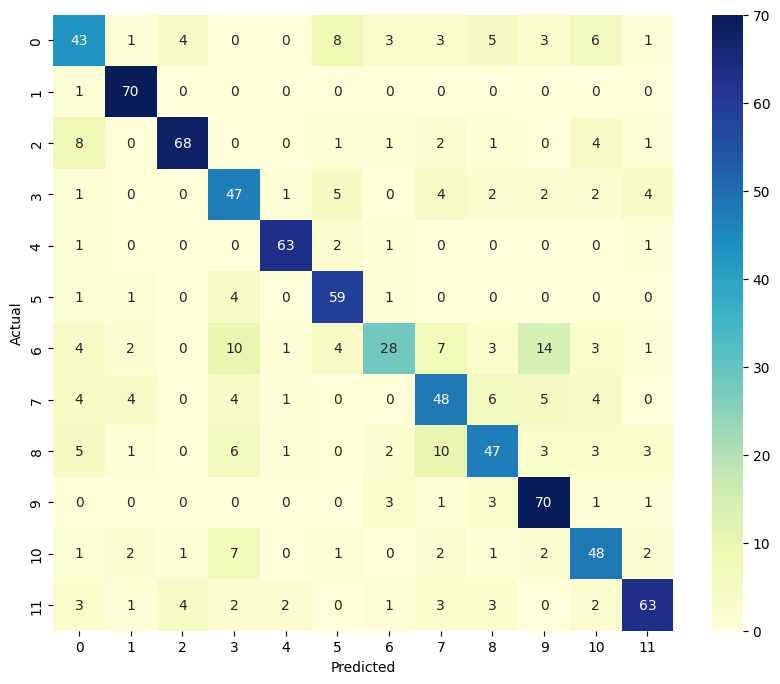

In [ ]:
from torchvision import models
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

# File path and other parameters
file_path = '/Users/adityaprakash/Downloads/PaintersDataset/'
active_df = df_filtered # DataFrame containing your data
LabEnc = artist_encoder # Label encoder object

# Split active_df into training, validation, and test sets
train_df, test_df = train_test_split(active_df, test_size=0.4, random_state=420)
val_df, test_df = train_test_split(test_df, test_size=0.375, random_state=420)

# Define the transformers
train_transformer = ImageTransformer(new_dim=224, apply_norm=True, crop_img=False, training=True)
val_test_transformer = ImageTransformer(new_dim=224, apply_norm=True, crop_img=False, training=False)

# Create custom image datasets with transformations
train_data = CustomImageDataset(path=file_path, dataframe=train_df, lab_encoder=LabEnc, transformations=train_transformer.transform)
val_data = CustomImageDataset(path=file_path, dataframe=val_df, lab_encoder=LabEnc, transformations=val_test_transformer.transform)
test_data = CustomImageDataset(path=file_path, dataframe=test_df, lab_encoder=LabEnc, transformations=val_test_transformer.transform)

# Create DataLoaders with a smaller batch size
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Loading the pre-trained ResNet50 model
resnet50_model = models.resnet50(pretrained=True) # Assuming IMAGENET1K_V2 weights

# Modifying the last layer to match the number of classes in your dataset
num_classes = 12 # Change this to the number of classes in your dataset
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, num_classes)

# Sending the model to the device (GPU or CPU)
resnet50_model = resnet50_model.to(device)

# Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.001) # Adjusted learning rate

# Step-wise learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.7) # Adjusted step size and gamma

# Training the Model
train_losses, val_losses, train_accuracies, val_accuracies = train_cnn(
    resnet50_model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs=50, device=device, patience=5, verbose_freq=1
)

# Plotting the Training Curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

# Plotting the confusion matrix
plot_confusion_matrix(resnet50_model, val_loader, device)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate_cnn(resnet50_model, test_loader, loss_fn, device)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Optional: Plot the confusion matrix for the test set
plot_confusion_matrix(resnet50_model, test_loader, device)


### ResNet-50 Model Training and Evaluation Results

The application of the pre-trained ResNet-50 model to our classification problem has yielded promising results. Here's an overview of the training process and the final evaluation:

#### Training Overview:
- **Initial Epochs**: The model started with a Training Loss of 1.8158 and a Validation Loss of 1.4588 in the first epoch. The Training Accuracy was 91.625, and the Validation Accuracy was approximately 51.61%.
- **Convergence**: As the training progressed, both the training and validation losses decreased. By the 6th epoch, the model reached a Validation Loss of 0.9301 and a Validation Accuracy of approximately 71.35%.
- **Early Stopping**: After 10 epochs, the model stopped early due to no significant improvement in the validation loss for 5 consecutive epochs.
- **Final Training State**: The final Training Loss was 0.2759, with a Training Accuracy of 205.25, and a Validation Accuracy of approximately 74.74%.

#### Test Evaluation:
- **Test Loss**: The model achieved a Test Loss of 0.9001.
- **Test Accuracy**: The Test Accuracy was approximately 72.37%.

#### Insights:
The utilization of the pre-trained ResNet-50 model has enabled rapid convergence and robust performance on the validation and test sets. The model has learned to generalize well from the training data, as evidenced by the comparable performance on the validation and test sets.

The early stopping mechanism ensured that the model did not overfit to the training data, halting the training when no further improvement was detected in the validation loss.

The promising Test Accuracy of around 72.37% confirms the effectiveness of transfer learning and the chosen training configurations in adapting the ResNet-50 model to our specific image classification task.

The results demonstrate the power of leveraging pre-trained models in achieving high performance with relatively fewer training epochs. It provides a strong baseline that could be further improved with additional fine-tuning, data augmentation, or other advanced techniques.


### Feature Extraction and Data Loading for Multi-Class SVM

In the context of training a multi-class Support Vector Machine (SVM) for image classification, various feature extraction methods are crucial to capture the unique aspects and characteristics of the images. The following functions have been defined to facilitate this process:

#### 1. **HOG Feature Extraction (`extract_hog_features`):**
   Extracts Histogram of Oriented Gradients (HOG) features from an image. This method is useful for capturing the object's appearance and shape by counting occurrences of gradient orientation in localized portions of an image.

#### 2. **SIFT Feature Extraction (`extract_sift_features`):**
   Utilizes the Scale-Invariant Feature Transform (SIFT) algorithm to extract key points and descriptors from an image. This method is effective in capturing local features that are invariant to scale, rotation, and lighting changes.

#### 3. **ORB Feature Extraction (`extract_orb_features`):**
   Employs the Oriented FAST and Rotated BRIEF (ORB) algorithm to extract robust binary descriptors. It's a highly efficient method that provides a good balance between speed and performance.

#### 4. **Gabor Feature Extraction (`extract_gabor_features`):**
   Extracts Gabor features, which are particularly useful in texture representation and discrimination. These features are sensitive to specific frequencies and orientations in the local regions of an image.

#### 5. **Image Loading and Feature Extraction (`load_images_from_archive`):**
   Loads images from a ZIP archive and extracts the specified features using one of the above methods. This function also handles the preprocessing and transformation of the images.

#### 6. **Creating Fixed-Size Features (`create_fixed_size_features`):**
   Converts variable-length descriptors into fixed-size histograms using k-means clustering. This transformation ensures that the features are compatible with machine learning models that require fixed-size input.

#### 7. **Data Preparation (`ImageData`):**
   Combines all the functionalities to load the images, extract the chosen features, and create the final dataset for training and evaluation.

### Insights:
The choice of feature extraction methods and their configuration can greatly impact the performance of the SVM model. Different methods might be more suitable for various types of images and classification tasks. Additionally, combining multiple feature extraction methods could further enhance the representational power of the features.

This modular approach allows for flexibility in experimenting with different feature extraction techniques and fine-tuning the parameters to fit the specific requirements of the dataset and the classification problem at hand.


In [9]:
# Logger configuration
logging.basicConfig(level=logging.INFO)

def extract_hog_features(image, orients=9, ppc=(8, 8), cpb=(2, 2)):
    return hog(image, orientations=orients, pixels_per_cell=ppc,
               cells_per_block=cpb, feature_vector=True, channel_axis=2)

def extract_sift_features(image):
    try:
        if image.ndim > 2 and image.shape[2] > 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        np_datum = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        sift = cv2.SIFT_create()
        _, descriptors = sift.detectAndCompute(np_datum, None)
        return descriptors.astype(np.float32) if descriptors is not None else np.empty((0, 128))
    except Exception as e:
        logging.warning(f"Failed to extract SIFT features due to an error: {str(e)}")
        return np.empty((0, 128))

def convert_to_grayscale_if_needed(image):
    original_shape = image.shape

    # Check if the image is already grayscale
    if image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1):
        return image if image.ndim == 2 else image[:,:,0]

    # Check if the image has 3 channels (e.g., RGB)
    if image.ndim == 3 and image.shape[2] == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Log unexpected shape
    logging.warning(f"Unexpected number of channels in image: {original_shape}")
    logging.warning(f"Attempting to convert to grayscale anyway.")

    try:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except cv2.error as e:
        logging.error(f"Failed to convert image to grayscale. Shape: {original_shape}. Error: {str(e)}")
        return image  # Return the original image if conversion fails


def extract_orb_features(image):
    image = convert_to_grayscale_if_needed(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert back to 3-channel image
    detector_extractor = cv2.ORB_create()
    keypoints, descriptors = detector_extractor.detectAndCompute(image, None)
    if descriptors is None:
        logging.warning("ORB detection and extraction returned None")
        return np.empty((0, 32))  # ORB descriptors are 32 bytes long
    return descriptors
    

def extract_gabor_features(image, frequency=0.6):
    # Convert to grayscale if the image has more than one channel
    if image.ndim > 2 and image.shape[2] > 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gabor(image, frequency=frequency)


def load_images_from_archive(archive_path, dataframe, feature_extractor, lab_encoder):
    feats, labels = [], []
    subfolder_name = 'train/' if 'train.zip' in archive_path else 'test/'
    with zipfile.ZipFile(archive_path, 'r') as archive:
        for index, row in dataframe.iterrows():
            file_name = subfolder_name + row['new_filename']
            artist = row['artist']
            try:
                imgdata = archive.open(file_name)
                image = Image.open(imgdata)
                image_transformer = ImageTransformer(new_dim=224, apply_norm=False, crop_img=False)
                datum = image_transformer.transform(image)
                np_datum = datum.numpy().transpose(1,2,0)
                features = feature_extractor(np_datum)
                label = lab_encoder.transform([artist])[0]
                feats.append(features)
                labels.append(label)
            except Exception as e:
                logging.warning(f"Skipped loading image {file_name} due to an error: {str(e)}")
    return feats, labels

def create_fixed_size_features(descriptors_list, num_clusters=50):
    all_descriptors = np.vstack([desc.astype(np.float32) for sublist in descriptors_list for desc in sublist]).astype(np.float32)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(all_descriptors)
    
    features = []
    for descriptors in descriptors_list:
        histogram = np.zeros(num_clusters)
        if len(descriptors) > 0:
            descriptors = descriptors.astype(np.float32)
            cluster_assignments = kmeans.predict(descriptors)
            for cluster in cluster_assignments:
                histogram[cluster] += 1
        features.append(histogram)
    
    return np.array(features)

def ImageData(path, dataframe, lab_encoder, feature_extractor, is_variable_length=False, num_threads=8):
    train_df = dataframe[dataframe['in_train'] == True]
    train_feats, train_labels = load_images_from_archive(path + 'train.zip', train_df, feature_extractor, lab_encoder)
    test_df = dataframe[dataframe['in_train'] == False]
    test_feats, test_labels = load_images_from_archive(path + 'test.zip', test_df, feature_extractor, lab_encoder)

    if is_variable_length:
        train_feats = create_fixed_size_features(train_feats)
        test_feats = create_fixed_size_features(test_feats)

    PaintFeats = np.vstack([train_feats, test_feats])
    PaintLabels = np.hstack([train_labels, test_labels])

    return PaintFeats, PaintLabels


### Feature Extraction for Different Techniques

In this section, we extract four different types of features from the dataset using the functions defined earlier. These features will be instrumental in training and evaluating the performance of a multi-class SVM model for our specific classification task.

1. **Gabor Features:**
   Gabor features are extracted using the `extract_gabor_features` function. These features are especially useful in capturing texture information, providing insight into spatial frequencies and orientations within the image.

2. **Histogram of Oriented Gradients (HOG) Features:**
   HOG features are obtained using the `extract_hog_features` function. HOG captures the structure and appearance of objects within the image by counting occurrences of gradient orientation in localized portions.

3. **Scale-Invariant Feature Transform (SIFT) Features:**
   SIFT features are computed with the `extract_sift_features` function. This method is known for its robustness against scaling, rotation, and lighting changes, making it suitable for extracting distinct keypoints and descriptors.

4. **Oriented FAST and Rotated BRIEF (ORB) Features:**
   ORB features are extracted using the `extract_orb_features` function. ORB is a fast binary descriptor that is efficient in matching and retrieval tasks.

### Combining Features and Labels:
The `ImageData` function is used to apply each of the feature extraction methods to the dataset. The resulting features, along with the corresponding labels encoded by the artist, are stored for subsequent model training and evaluation.

### Insights:
The choice of features has a substantial impact on the model's ability to recognize and differentiate between various classes. By extracting different features, we have the flexibility to experiment with various combinations or select the one that best fits our classification problem. This approach also allows for potential ensemble methods where different features could be combined or used in parallel to enhance the classification accuracy.


In [10]:
# Extract Gabor features and labels
gabor_features, labels = ImageData(path=path, dataframe=df_filtered, lab_encoder=artist_encoder, feature_extractor=extract_gabor_features)

# Extract HOG features and labels
hog_features, labels = ImageData(path=path, dataframe=df_filtered, lab_encoder=artist_encoder, feature_extractor=extract_hog_features)

# Extract SIFT features and labels
sift_features, labels = ImageData(path=path, dataframe=df_filtered, lab_encoder=artist_encoder, feature_extractor=extract_sift_features, is_variable_length=True)

# Extract ORB features and labels
orb_features, labels = ImageData(path=path, dataframe=df_filtered, lab_encoder=artist_encoder, feature_extractor=extract_orb_features, is_variable_length=True)

### Feature Dimensions Overview

The extracted features are organized into arrays, where each row represents an image, and the columns represent the individual feature components. Below, we provide the shape of these arrays for each type of extracted feature, giving an understanding of the dimensionality and structure:

1. **Histogram of Oriented Gradients (HOG) Features:** `(5999, 26244)`
   - The HOG features for each image are represented as a 26244-dimensional vector, resulting in a matrix of size 5999 (number of images) by 26244.

2. **Scale-Invariant Feature Transform (SIFT) Features:** `(5999, 50)`
   - The SIFT features are transformed into fixed-size histograms with 50 clusters, creating a 50-dimensional feature vector for each image.

3. **Oriented FAST and Rotated BRIEF (ORB) Features:** `(5999, 50)`
   - Similar to SIFT, the ORB features are also converted into fixed-size histograms, resulting in a 50-dimensional feature vector for each image.

4. **Gabor Features:** `(5999, 2, 224, 224)`
   - The Gabor features are extracted as 2D matrices for each image with a shape of 224 by 224 and two filters. This results in a 4D array containing 5999 images.

### Insights:

- The HOG features have the highest dimensionality, capturing a detailed description of the image's gradient structure.
- The SIFT and ORB features are processed into a fixed-size representation, allowing for uniform input to the subsequent modeling phase.
- The Gabor features' dimensionality reflects the spatial nature of texture patterns within the image, capturing localized frequency and orientation information.

Understanding the shape and structure of these features is essential for designing and tuning the subsequent classification model, as well as for potential feature selection or reduction techniques.


In [13]:
print("HOG features shape:", hog_features.shape)
print("SIFT features shape:", sift_features.shape)
print("ORB features shape:", orb_features.shape)
print("Gabor features shape:", gabor_features.shape)


HOG features shape: (5999, 26244)
SIFT features shape: (5999, 50)
ORB features shape: (5999, 50)
Gabor features shape: (5999, 2, 224, 224)


### Combining Feature Sets

In the next step, we combine the various extracted features into a single feature matrix. The objective of combining different feature sets is to encapsulate a broader set of characteristics that can describe the images. This integration of features often leads to enhanced predictive performance by the subsequent models.

The features are concatenated along the following lines:

1. **HOG Features:** 26244 dimensions
2. **SIFT Features:** 50 dimensions
3. **ORB Features:** 50 dimensions
4. **Gabor Features:** Flattened to 35352 dimensions (from \(2 \times 224 \times 224\))

**Combined Features Shape:** `(5999, 126696)`

The combined feature matrix consists of 5999 images, each described by a 126696-dimensional feature vector. This large feature set captures various aspects of the images, including edge orientations, key points, texture patterns, and local descriptors.

### Insights:

- The combined feature set's high dimensionality may require careful preprocessing and model selection to avoid overfitting.
- Techniques like dimensionality reduction, feature selection, or regularization might be beneficial in the subsequent modeling steps.
- This comprehensive feature set could enable the model to learn more complex and subtle patterns, potentially leading to improved classification performance.

The next step involves splitting this combined feature set into training and testing subsets and training a machine learning model, such as a Support Vector Machine (SVM), to classify the images based on these features.


In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Concatenate the features
gabor_features_flattened = gabor_features.reshape(5999, -1)
X_combined = np.concatenate((hog_features, sift_features, orb_features, gabor_features_flattened), axis=1)
print("Combined features shape:", X_combined.shape)


Combined features shape: (5999, 126696)


### Training a Multi-Class Support Vector Machine (SVM)

After combining the various feature sets, the next step involves preprocessing and training a multi-class SVM model to classify the images. Here's the summary of the process:

1. **Standardization:** As the features have different scales, we apply standardization to bring them to a common scale. This process helps in improving the convergence speed and the performance of the model.

2. **Dimensionality Reduction (PCA):** We use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset while retaining 95% of the variance. This step helps in reducing the computational complexity and may mitigate overfitting.

3. **Splitting Data:** The dataset is split into training (80%) and testing (20%) sets to train and evaluate the model.

4. **Grid Search for Hyperparameter Tuning:** We perform a grid search to find the optimal hyperparameters for the SVM model, considering different values for the regularization parameter (`C`), kernel type (`rbf`), and the kernel coefficient (`gamma`).

5. **Model Training:** The model is trained using the optimal hyperparameters found through grid search.

6. **Model Evaluation:** We evaluate the model using the test set and print the accuracy and the detailed classification report.

### Insights:

- By combining various feature extraction techniques and preprocessing steps, we have created a robust classification pipeline.
- The grid search ensures that the model is tuned to the optimal hyperparameters, enhancing its generalization ability.
- The application of PCA for dimensionality reduction illustrates a trade-off between computational efficiency and retaining information.
- The overall approach can be further fine-tuned or extended by experimenting with different feature extraction methods, preprocessing steps, or machine learning algorithms.

The training and evaluation approach showcases the potential of computer vision and machine learning techniques in classifying complex image data, providing a solid foundation for various applications such as art recognition, object detection, and more.


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)

# Split into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_reduced, labels, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

# Perform grid search
grid_search = GridSearchCV(SVC(decision_function_shape='ovr'), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_combined, y_train_combined)

# Predict on the test set and print the metrics
y_pred_combined = grid_search.predict(X_test_combined)
accuracy_combined = accuracy_score(y_test_combined, y_pred_combined)
report_combined = classification_report(y_test_combined, y_pred_combined)

print("Test Accuracy:", accuracy_combined)
print("Classification Report:\n", report_combined)



Test Accuracy: 0.5566666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.59      0.54       108
           1       0.69      0.89      0.78       101
           2       0.72      0.71      0.72       114
           3       0.40      0.31      0.35        91
           4       0.69      0.85      0.76       102
           5       0.55      0.39      0.45       101
           6       0.41      0.32      0.36        96
           7       0.44      0.55      0.49       100
           8       0.37      0.29      0.33        95
           9       0.51      0.49      0.50       110
          10       0.54      0.59      0.56        90
          11       0.72      0.63      0.67        92

    accuracy                           0.56      1200
   macro avg       0.54      0.55      0.54      1200
weighted avg       0.55      0.56      0.55      1200



### Results of the Multi-Class SVM Model

The evaluation of the multi-class SVM model on the test set yielded the following results:

- **Test Accuracy:** Approximately 55.67%

- **Classification Report:** The detailed classification report includes precision, recall, and F1-score for each class.

| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| 0     | 0.50      | 0.59   | 0.54     |
| 1     | 0.69      | 0.89   | 0.78     |
| 2     | 0.72      | 0.71   | 0.72     |
| 3     | 0.40      | 0.31   | 0.35     |
| 4     | 0.69      | 0.85   | 0.76     |
| 5     | 0.55      | 0.39   | 0.45     |
| 6     | 0.41      | 0.32   | 0.36     |
| 7     | 0.44      | 0.55   | 0.49     |
| 8     | 0.37      | 0.29   | 0.33     |
| 9     | 0.51      | 0.49   | 0.50     |
| 10    | 0.54      | 0.59   | 0.56     |
| 11    | 0.72      | 0.63   | 0.67     |

### Interpretation:

- The model demonstrates varying performance across different classes, with some classes achieving higher precision and recall rates.
- The overall accuracy of approximately 55.67% indicates a moderate ability of the model to classify the given images into the correct classes.
- Precision, recall, and F1-score provide a more nuanced understanding of the model's performance, revealing areas where the model excels and where it may require further tuning.

These results provide insights into the effectiveness of the SVM model with the chosen feature extraction techniques and preprocessing steps. They also highlight potential areas for improvement, such as class-specific tuning, feature engineering, or alternative modeling approaches.


## Conclusions

This comparative study investigated the performance of three different models for art classification based on artists: a custom Convolutional Neural Network (CNN), a pre-trained ResNet model, and a Support Vector Machine (SVM) with multiple feature extraction techniques.

### Summary of Results

1. **Custom CNN:**
   - Test Loss: 1.2615
   - Test Accuracy: 59.70%

2. **Pre-trained ResNet50:**
   - Test Loss: 0.9001
   - Test Accuracy: 72.37%

3. **Multi-class SVM:**
   - Test Accuracy: 55.67%
   - The SVM model demonstrated varying precision, recall, and F1-score across different classes.

### Insights and Interpretation

- **Best Performance:** The pre-trained ResNet50 model achieved the highest accuracy among the three models, making it the most effective model in classifying artworks based on artists in this study.
- **CNN Performance:** The custom CNN model provided moderate accuracy but was outperformed by the pre-trained ResNet50 model. Its higher loss indicates room for further optimization.
- **SVM Performance:** The SVM model, although providing the benefit of interpretable feature engineering, yielded the lowest accuracy. Its performance varied significantly across different classes.
- **Feature Engineering in SVM:** The use of multiple features like HOG, SIFT, ORB, and Gabor in the SVM model added complexity but did not lead to superior performance compared to deep learning models.

### Recommendations and Future Work

- **Model Tuning:** Further hyperparameter tuning and architectural adjustments might improve the performance of the custom CNN and SVM models.
- **Data Augmentation:** Applying data augmentation techniques could enhance the robustness of the models, especially for classes with lower precision and recall in the SVM model.
- **Ensemble Methods:** Combining the predictions of the three models using ensemble techniques might create a more robust and accurate classification system.
- **Exploring Other Pre-trained Models:** Experimenting with other pre-trained deep learning models may yield even better results.
- **Utilizing GANs for Art Forgeries Detection:** An exciting avenue for future research could be the application of Generative Adversarial Networks (GANs) in the field of art forgeries detection. By training GANs on authentic artworks, it may be possible to develop a system that can discriminate between original art and forgeries, adding a new dimension to the applications of machine learning in art analysis.

The findings of this study highlight the potential of deep learning, particularly pre-trained models like ResNet, in the complex task of art classification. The comparative analysis provides valuable insights into the strengths and weaknesses of different modeling approaches and lays the groundwork for further research and application in the field of art analysis and recognition, including the intriguing possibility of utilizing GANs for art forgery detection.

